# Spatial Segmentation and Drivers of Energy Consumption in England and Wales

#### *Exploring Socioeconomic Influences and Consumption Patterns Among Energy Consumers in England and Wales*

Word count: 1992

In [1697]:
# load relevant packages for analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 1.0 Introduction & Literature Review

After economic sanctions were imposed on [Russian oil in 2022](https://www.consilium.europa.eu/en/policies/eu-response-ukraine-invasion/impact-of-russia-s-invasion-of-ukraine-on-the-markets-eu-response/#:~:text=In%202022%2C%20the%20price%20of,states%20further%20impacted%20the%20situation.), energy prices in Europe surged. This sparked public discontent and prompted domestic relief payments. While these payments provided temporary relief, investigating domestic energy consumption could boost the UK's long-term resilience against price fluctuations and reduce costs for those most vulnerable through targeted policy. With this in mind, the objective of this study is to identify socioeconomic factors that are correlated with *High, Medium* and *Low* energy consumption.

This paper groups consumers based on similar energy usage and location through unsupervised clustering. Initially, clustering the population allows us to identify natural groupings based on energy use and geographical proximity (Jain & Ahuja, 2014). This approach provides an optimal level of specificity — neither too granular nor too broad - facilitating the development of targeted policies that effectively address the distinct needs of these well-defined groups (Balashankar et al., 2022; Soto et al., 2021).

We then classify these groups into four energy consumption *segments*: *High, Medium-High, Medium-Low,* and *Low*. Finally, we employ muliple linear regression to examine the socioeconomic factors correlated with each energy consumption category. 

Developing targeted policy involves four steps, market segmentation, segment analysis, policy implementation and ongoing monitoring (Soto et al., 2021). This paper conducts the initial two steps, due to its analytical nature.

Segmentation is crucial for creating targeted policies by identifying distinct groups within a population (Soto et al., 2021). Clustering, particularly K-means, is a potent tool for effectively delineating target populations, as it groups  based common characteristics, is suitable for spatial data and not computationally expensive (Balashankar et al., 2022; Jain & Ahuja, 2014).

The next step involves understanding the characteristics of these consumer segments. Multiple linear regression is commonly used to analyse the influence of multiple independent varibles on a dependent variable, such as the impact of  socioeconomic factors on energy consumption (Balashankar et al., 2022).

The Office for National Statistics commonly reports three socioeconomic factors alongside energy consumption: 1. Central Heating Type—key for understanding energy consumption due to its direct impact on heating efficiency. 2. Income Level and 3. Dwelling Type—important for indicating the economic ability to invest in energy-efficient solutions and the physical characteristics of homes that affect energy needs. Thus, this study will investigate the influence of these three factors on energy consumption

With this in mind, this paper investigates 3 research questions.

        RQ1 | Can unsupervised clustering effectively segment the English and Welsh population based on electricity and gas consumption behaviour?
        RQ2 | How do central heating type, income level and dwelling type correlate with *High, Medium-High, Medium-Low,* and *Low* energy consumption in England and Wales?

## 2.0 Methodology

This study will use open data from the Office of National Statistics (ONS) and energy consumption records from the UK Department for Energy Security and Net Zero (DESNZ) from 2022. The energy data is provided at postcode level, while socioeconomic data are by Local Authority District (LAD). To address this, we'll cluster at the postcode level, then map these clusters to LADs. Where clusters span multiple LADs, we'll use a weighted average of energy consumption based on the number of postcodes per LAD, ensuring accurate geographical representation of the data.

The analysis consists of two main parts. Initially, consumer grouping will be conducted using unsupervised clustering based on geography and energy consumption, avoiding the initial influence of socio-economic factors. This approach, as Słupik et al. (2021) suggest, establishes baseline segments reflecting geographic and usage interactions and allows for the methodical addition of more variables if the study progresses.

We'll employ the elbow method, silhouette analysis and the Calinski-Harabasz index to determine the optimal number of clusters. Clusters will be divided into consumption quartiles: *High consumption, Medium-High consumption, Medium-Low consumption*, and *Low consumption*. 

Following segmentation, the study will examine which characteristics correlate with different levels of energy consumption, focusing on factors like income, central heating type and dwelling type. This correlation analysis will utilise multiple linear regression to assess how these predictors affect energy consumption across segments, providing a statistically robust foundation for targeted policy recommendations (Forootan et al., 2022; Dou et al., 2023). This method not only quantifies relationship strengths but also accounts for variable interdependencies, enhancing the analysis's accuracy and relevance for policy-making.

## 3.0 Data Overview, Processing & Exploration

This section processes the data this study and provides an overview of the fields, the shape and distribution of the data.  This includes checking for outliers and inconsistencies.

The energy consumption from the DESNZ is provided at outcode level without geometry. The geopy library automatically finds and builds a geometry column based on outcode. DESNEZ provide mean, median and total electricity and gas consumption data by Kilowatt-hour (kWh). Below we drop both the *Mean* and *Total* consumption column and use *Median* annual electricity and gas consumption as it is least impacted by outliers. For this reason we do not normalise by population.

[geopy](https://geopy.readthedocs.io/en/stable/) can assign one postcode per second and is computationally intensive, thus, we run this on the gas consumption data and join electricity data later.

### 3.1 Read in Energy Consumption Data, Process and add Geometry

In [723]:
# read in desnez data
gas_df = pd.read_csv('data/gas_consumption.csv')
elec_df = pd.read_csv('data/electricity_consumption.csv')
outpop_df = pd.read_csv('data/outcode_population.csv') # pop. by outcode to normalise cons. data

In [725]:
# the following is a computational intense process and was run when this analysis was originally conducted. 
# the new CSV file is read in below the following four code chunks.

# init. geolocator
#geolocator = Nominatim(user_agent="geoapiExercises")

# function to get lat / long
#def get_lat_lon(outcode):
    #try:
        #location = geolocator.geocode(f"{outcode}, United Kingdom")
        #return (location.latitude, location.longitude)
    #except:
        #return (None, None)

# avoid hitting rate limits
#geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# apply to outcode column
#gas_df['Latitude_Longitude'] = gas_df['outcode'].apply(lambda x: get_lat_lon(x))

#gas_df.to_csv('data/gas_df.csv', index=False)

In [2887]:
gas_df = pd.read_csv('data/gas_df.csv')

In [2888]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   outcode              2410 non-null   object 
 1   gas_total_cons_kwh   2410 non-null   float64
 2   gas_mean_cons_kwh    2410 non-null   float64
 3   gas_median_cons_kwh  2410 non-null   float64
 4   Latitude_Longitude   2410 non-null   object 
dtypes: float64(3), object(2)
memory usage: 94.3+ KB


In [2889]:
# convert string coordinates to a point object
def parse_coordinates(coord_str):
    if coord_str == "None, None":
        return None
    try:
        lat, lon = coord_str.strip('()').split(',')
        return Point(float(lon.strip()), float(lat.strip()))
    except (ValueError, TypeError):
        return None

# 'Latitude_Longitude' as geometry
gas_df['geometry'] = gas_df['Latitude_Longitude'].apply(parse_coordinates)

# remove 'None'
gas_df = gas_df[gas_df['geometry'].notna()]

# df to gdf
gas_gdf = gpd.GeoDataFrame(gas_df, geometry='geometry')

# WGS 84 CRS
gas_gdf.set_crs(epsg=4326, inplace=True)

# join electricity data by outcode
energycon_gdf = pd.merge(gas_gdf, elec_df, on='outcode', how='inner')

# drop total & mean consumption columns
columns_to_drop = ['gas_total_cons_kwh', 'gas_mean_cons_kwh', 'elec_total_cons_kwh', 'elec_mean_cons_kwh', 'Latitude_Longitude']
energycon_gdf = energycon_gdf.drop(columns=columns_to_drop)

In [2890]:
# normalise our energy consumption data by outcode population 
# perform inner join
energycon_gdf = pd.merge(
    energycon_gdf,
    outpop_df[['Postcode Districts', 'Count']],
    left_on='outcode',
    right_on='Postcode Districts',
    how='inner'
)

# normalise x population count
energycon_gdf['n_gas_median_cons_kwh'] = energycon_gdf['gas_median_cons_kwh'] / energycon_gdf['Count']
energycon_gdf['n_elec_median_cons_kwh'] = energycon_gdf['elec_median_cons_kwh'] / energycon_gdf['Count']

# drop 'Postcode Districts'
energycon_gdf.drop(columns=['Postcode Districts'], inplace=True)

# calc mean and standard deviation
mean_values = energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']].mean()
std_dev = energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']].std()

# detect and remove outliers more than 2 StD. from the mean
is_outlier = ((energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']] < (mean_values - 2 * std_dev)) |
              (energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']] > (mean_values + 2 * std_dev))).any(axis=1)
energycon_gdf = energycon_gdf[~is_outlier]

# save
energycon_gdf.to_file('energycon.gpkg', driver='GPKG')

In [2891]:
# read in processed 'energy consumption data' & check
energycon_gdf = gpd.read_file('energycon.gpkg')
energycon_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   outcode                 1429 non-null   object  
 1   gas_median_cons_kwh     1429 non-null   float64 
 2   elec_median_cons_kwh    1429 non-null   float64 
 3   Count                   1429 non-null   int64   
 4   n_gas_median_cons_kwh   1429 non-null   float64 
 5   n_elec_median_cons_kwh  1429 non-null   float64 
 6   geometry                1429 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 78.3+ KB


In [2892]:
numeric_cols = energycon_gdf.select_dtypes(include=[np.number])

# descriptive stats
basic_stats = numeric_cols.describe()

# count of non-null entries
nonnull_counts = energycon_gdf.count()

# data types
data_types = energycon_gdf.dtypes

# quantiles
quantiles = numeric_cols.quantile([0.25, 0.5, 0.75])

# correlation matrix
correlation_matrix = numeric_cols.corr()

# display
print("Descriptive Statistics:\n", basic_stats)
print("\nCount of Non-Null Entries:\n", nonnull_counts)
print("\nData Types:\n", data_types)
print("\nQuantiles:\n", quantiles)
print("\nCorrelation Matrix:\n", correlation_matrix)

Descriptive Statistics:
        gas_median_cons_kwh  elec_median_cons_kwh          Count  \
count          1429.000000           1429.000000    1429.000000   
mean          10095.291839           2611.974050   27664.167950   
std            1998.934236            352.451779   17787.980163   
min            3728.318537           1577.100000      55.000000   
25%            8926.833145           2392.400000   14852.000000   
50%            9815.550000           2542.000000   25310.000000   
75%           10889.086886           2772.200000   36906.000000   
max           28575.457630           5444.500000  170304.000000   

       n_gas_median_cons_kwh  n_elec_median_cons_kwh  
count            1429.000000             1429.000000  
mean                1.340411                0.339435  
std                 8.360627                2.049145  
min                 0.059852                0.014346  
25%                 0.256299                0.066603  
50%                 0.386284             

#### We infer the following conclusions about the data:
- **Consumption Variability:** The dataset from 1,429 outcodes shows a median gas consumption range of 3,728 to 28,575 kWh, with electricity consumption being less variable, ranging from 1,577 to 5,444 kWh. Median gas consumption is 9,815 kWh.
- **Correlation and Efficiency:** There's a moderate correlation (about 0.46) between gas and electricity consumption, suggesting that higher gas usage often aligns with higher electricity usage. Normalised consumption values reveal efficiencies of about 1.34 kWh for gas and 0.34 kWh for electricity per unit count, with some regions showing exceptionally high usage.
- **Statistical Overview:** The dataset exhibits a broad population range from 55 to 170,304, suggesting diverse outcode sizes. The strong correlation (0.977) between normalised gas and electricity values underscores consistent regional energy usage patterns.

Below, we read and process the socio-economic data. There are five fields taken from four datasets recorded by LAD. The population, dwelling type, central heating type and income data all comes from the ONS. This data is merged with LAD polygon data, also provided by the ONS. 

The socio-economic data is provided as raw counts, thus, we conduct per capita normalisation to ensure our analysis is accurate. During the normalisation process we deal with NaN and 0 values.

### 3.2 Read in Socio-Economic Data, Process and add Geometry column

In [2895]:
# read in ONS socioeconomic & LAD geometry data
income = pd.read_csv('data/annual_income.csv') # annual income
heat_type = pd.read_csv('data/heating_type.csv') # central heating type
dw_type = pd.read_csv('data/accomodation_type.csv') # dwelling type
lad = gpd.read_file("data/Local_Authority_Districts/LAD_MAY_2022_UK_BFE_V3.shp") # lad polygon data
pop = pd.read_excel("data/population.xlsx") # pop

In [2896]:
# process and clean income data
median_income = income.groupby('Local authority code')['Total annual income (£)'].median().reset_index()

# rename 'med average annual income' & print
median_income.rename(columns={'Total annual income (£)': 'Med average annual income (£)'}, inplace=True)
median_income.rename(columns={'Local authority code': 'Lower tier local authorities Code'}, inplace=True)
median_income.head(2)

,Lower tier local authorities Code,Med average annual income (£)
0,E06000001,31050.0
1,E06000002,35500.0


In [2897]:
# process heating & dwelling type data
# pivot heating type
heatpivot_df = heat_type.pivot(
    index='Lower tier local authorities Code',
    columns='Type of central heating in household (5 categories)',
    values='Observation'
)

# 'LAD Code' as index
heatpivot_df.reset_index(inplace=True)

# pivot 'dw type'
dwpivot_df = dw_type.pivot(index='Lower tier local authorities Code', 
                         columns='Accommodation type (5 categories)', 
                         values='Observation')

# 'LAD Code' as index
dwpivot_df.reset_index(inplace=True)

In [2898]:
# merge 'dwpivot_df' and 'heatpivot_df' on 'Lower tier local authorities Code'
merged_df = pd.merge(dwpivot_df, heatpivot_df, on='Lower tier local authorities Code', how='outer')

# merge with 'income' on 'Lower tier local authorities Code'
socec_df = pd.merge(merged_df, median_income, on='Lower tier local authorities Code', how='outer')

# display
socec_df.head(2)

,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Med average annual income (£)
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,0.0,342.0,36686.0,180.0,3722.0,31050.0
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,0.0,752.0,53648.0,178.0,5684.0,35500.0


In [2899]:
# merge 'LAD' and 'socec_df' geographic data
lad_filtered = lad[['LAD22CD', 'geometry']]

# keep all 'socec_df' columns and only 'geometry' from 'lad'
socec_df = pd.merge(socec_df, lad_filtered, how='left', left_on='Lower tier local authorities Code', right_on='LAD22CD')

# drop 'LAD22CD' & display
socec_df.drop(columns=['LAD22CD'], inplace=True)

In [2900]:
# final cleaning
# drop
socec_df.drop(columns=['Does not apply'], inplace=True)

# rename index as 'LAD'
socec_df.rename(columns={'Lower tier local authorities Code': 'LAD'}, inplace=True)

# geometry as last column
geometry = socec_df.pop('geometry')
socec_df['geometry'] = geometry

# rename
column_rename_map = {
    'A caravan or other mobile or temporary structure': 'dwelling_type: mobile',
    'Flat, maisonette or apartment': 'dwelling_type: flat',
    'Whole house or bungalow: Detached': 'dwelling_type: detached house',
    'Whole house or bungalow: Semi-detached': 'dwelling_type: semi-detached',
    'Whole house or bungalow: Terraced': 'dwelling_type: terraced',
    'Does not have central heating': 'no central heating',
    'Has one type of central heating': '1 central heating',
    'Two or more types of central heating (including renewable energy)': '2+ central heating (renewable)',
    'Two or more types of central heating (not including renewable energy)': '2+ central heating (non-renewable)',
    'Med average annual income (£)': 'mean annual income'
}
socec_df.rename(columns=column_rename_map, inplace=True)

# print
socec_df.head(2)

,LAD,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,342.0,36686.0,180.0,3722.0,31050.0,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,752.0,53648.0,178.0,5684.0,35500.0,"POLYGON ((448489.897 522071.798, 448592.597 52..."


In [2901]:
# normalise these values by the population of each LAD 
# start by adding population to df:
# left join data using 'socec_df' as master
pop_filtered = pop[['Code', 'All ages']]
socec_df = pd.merge(socec_df, pop_filtered, how='left', left_on='LAD', right_on='Code')

# rename 'All ages' column to 'population' and drop redundant 'Code' column
socec_df.rename(columns={'All ages': 'population'}, inplace=True)
socec_df.drop(columns=['Code'], inplace=True)

In [2902]:
# normalise all the necessary fields
# columns to normalise
columns_to_normalise = [
    'dwelling_type: mobile', 'dwelling_type: flat', 'dwelling_type: detached house',
    'dwelling_type: semi-detached', 'dwelling_type: terraced',
    'no central heating', '1 central heating',
    '2+ central heating (renewable)', '2+ central heating (non-renewable)'
]

# remove rows where pop is NaN / 0
cleaned_df = socec_df[socec_df['population'].notna() & (socec_df['population'] > 0)]

# new df for normalised data
nsocec_df = cleaned_df[['LAD', 'geometry', 'mean annual income']].copy()

# normalise each column by population & display
for column in columns_to_normalise:
    nsocec_df[column] = cleaned_df[column] / cleaned_df['population']
nsocec_df.head(2)

,LAD,geometry,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable)
0,E06000001,"POLYGON ((447213.900 537036.104, 447228.798 53...",31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654
1,E06000002,"POLYGON ((448489.897 522071.798, 448592.597 52...",35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332


In [2903]:
# convert to gdf using epsg:4326
nsocec_gdf = gpd.GeoDataFrame(nsocec_df, geometry='geometry')
nsocec_gdf.set_crs("epsg:4326", inplace=True, allow_override=True)
nsocec_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 314 entries, 0 to 330
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   LAD                                 314 non-null    object  
 1   geometry                            314 non-null    geometry
 2   mean annual income                  301 non-null    float64 
 3   dwelling_type: mobile               314 non-null    float64 
 4   dwelling_type: flat                 314 non-null    float64 
 5   dwelling_type: detached house       314 non-null    float64 
 6   dwelling_type: semi-detached        314 non-null    float64 
 7   dwelling_type: terraced             314 non-null    float64 
 8   no central heating                  314 non-null    float64 
 9   1 central heating                   314 non-null    float64 
 10  2+ central heating (renewable)      314 non-null    float64 
 11  2+ central heating (non-renew

The socioeconomic data is merged and formatted. Below we produce the summary statistics for each field.

In [2905]:
# summary statistics for numeric fields
numeric_stats = nsocec_gdf.describe()

# statistics for 'geometry'
if 'geometry' in nsocec_gdf.columns:
    geometry_types = nsocec_gdf['geometry'].geom_type.value_counts()

# numeric statistics
print("Numeric Fields Summary Statistics:\n", numeric_stats)

# print the geometry statistics
if 'geometry' in nsocec_gdf.columns:
    print("\nGeometry Types:\n", geometry_types)

Numeric Fields Summary Statistics:
        mean annual income  dwelling_type: mobile  dwelling_type: flat  \
count          301.000000             314.000000           314.000000   
mean         46630.232558               0.002067             0.082017   
std           9870.109740               0.002098             0.065401   
min          31050.000000               0.000000             0.017910   
25%          39000.000000               0.000503             0.044090   
50%          44600.000000               0.001333             0.063788   
75%          53350.000000               0.002957             0.094242   
max         101800.000000               0.013217             0.443809   

       dwelling_type: detached house  dwelling_type: semi-detached  \
count                     314.000000                    314.000000   
mean                        0.108347                      0.130504   
std                         0.055624                      0.037655   
min                       

The average mean annual income across the 301 entries is approximately £46,630, but the range is quite broad, with a maximum income reported as £101,800. The normalised dwelling data reveals a predominance of flats and semi-detached houses, with relatively minor variations in central heating systems, suggesting a general uniformity in dwelling types and heating across the sampled regions.

The presence of missing data in 'mean annual income' alongside its lack of normalisation may skew comparative analyses, especially when compared to other per capita normalised metrics.

In [2907]:
# address missing data in 'mean annual income'
print(f"Missing data in 'mean annual income' before cleanup: {nsocec_gdf['mean annual income'].isna().sum()}")
nsocec_gdf['mean annual income'].fillna(nsocec_gdf['mean annual income'].median(), inplace=True)
print(f"After imputing missing values with median: {nsocec_gdf['mean annual income'].isna().sum()}")

# ensure geometry consistency
nsocec_gdf['geometry'] = nsocec_gdf['geometry'].apply(lambda x: x if x.is_valid else x.buffer(0))
nsocec_gdf = nsocec_gdf.explode('geometry', index_parts=True)

# correct data type inconsistencies
nsocec_gdf['mean annual income'] = pd.to_numeric(nsocec_gdf['mean annual income'], errors='coerce')

# status report
print("\nData Types in DataFrame:")
nsocec_gdf.head()

Missing data in 'mean annual income' before cleanup: 13
After imputing missing values with median: 0

Data Types in DataFrame:


,,LAD,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),geometry
0,0,E06000001,31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654,"POLYGON ((447213.89950 537036.10450, 447228.79..."
1,0,E06000002,35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332,"POLYGON ((448489.89690 522071.79790, 448592.59..."
2,0,E06000003,34000.0,0.000612,0.040066,0.090753,0.203696,0.114204,0.004148,0.403251,0.002260,0.039679,"POLYGON ((455525.93100 528406.65420, 455724.63..."
3,0,E06000004,35850.0,0.000395,0.038392,0.111064,0.177500,0.091506,0.003526,0.376619,0.001975,0.036736,"POLYGON ((444157.00190 527956.30350, 444165.89..."
4,0,E06000005,36100.0,0.000713,0.058683,0.085239,0.174917,0.127315,0.004257,0.404863,0.002074,0.035681,"POLYGON ((423496.60200 524724.29870, 423497.20..."


In [2908]:
nsocec_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 446 entries, (0, 0) to (330, 0)
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   LAD                                 446 non-null    object  
 1   mean annual income                  446 non-null    float64 
 2   dwelling_type: mobile               446 non-null    float64 
 3   dwelling_type: flat                 446 non-null    float64 
 4   dwelling_type: detached house       446 non-null    float64 
 5   dwelling_type: semi-detached        446 non-null    float64 
 6   dwelling_type: terraced             446 non-null    float64 
 7   no central heating                  446 non-null    float64 
 8   1 central heating                   446 non-null    float64 
 9   2+ central heating (renewable)      446 non-null    float64 
 10  2+ central heating (non-renewable)  446 non-null    float64 
 11  geometry      

## 4.0 Analysis: Segmentation of English and Welsh Energy Consumers: Unsupervised Clustering

Below, we leverage unsupervised spatial clustering to group consumers based on energy consumption and geography. These groups will then be categorised into four segments:
- High: Top 25% of consumption
- Medium-High: 50-75% of consumption
- Medium-Low: 25-50% of consumption
- Low: Bottom 25% of consumption

In our study of English and Welsh energy consumption, we applied the K-Means clustering algorithm to group consumers based on usage and location. The optimal number of groups was determined using the elbow method, silhouette analysis, and the Calinski-Harabasz index which identify the point where the increase in clusters ceases to significantly reduce the within-cluster sum of squares.

The effectiveness of the clusters was evaluated using the Silhouette Score, a measure of how well-separated the clusters are relative to their proximity. High Silhouette Scores indicate well-defined clusters, supporting the robustness of our clustering approach, which is crucial for informed energy policy development.

In [2910]:
# read consumption data & view
gdf = gpd.read_file('energycon.gpkg')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   outcode                 1429 non-null   object  
 1   gas_median_cons_kwh     1429 non-null   float64 
 2   elec_median_cons_kwh    1429 non-null   float64 
 3   Count                   1429 non-null   int64   
 4   n_gas_median_cons_kwh   1429 non-null   float64 
 5   n_elec_median_cons_kwh  1429 non-null   float64 
 6   geometry                1429 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 78.3+ KB


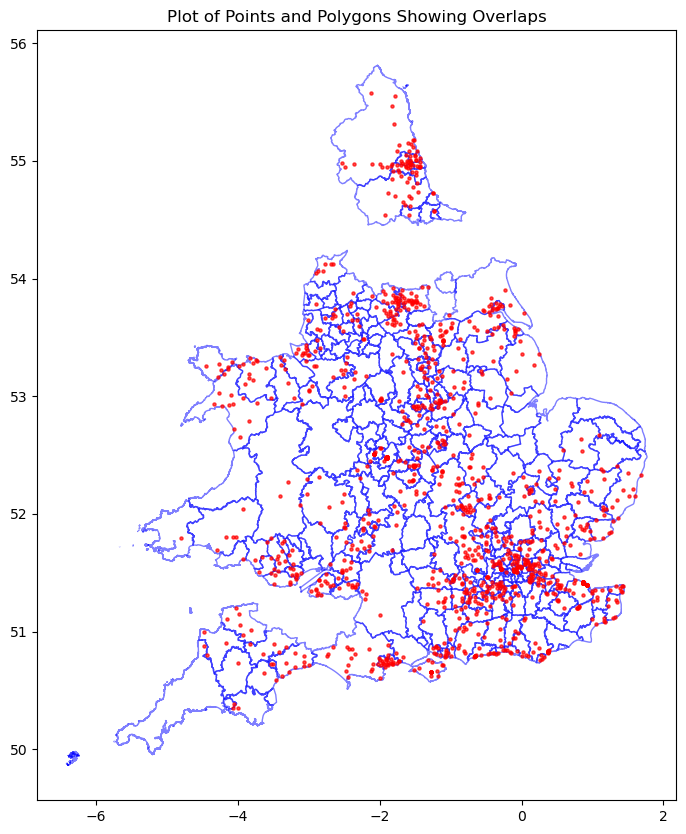

In [2911]:
# here we conduct a spatial join and remove all energy consumption point data if it does not align with a LAD with socec data
# convert CRS to EPSG:4326
nsocec_gdf = nsocec_gdf.set_crs("EPSG:27700", allow_override=True)
nsocec_gdf = nsocec_gdf.to_crs("EPSG:4326")

# inner spatial join to keep only overlapping geometries
joined_df = gpd.sjoin(gdf, nsocec_gdf, how='inner', predicate='intersects')

# drop 'index_right0' & 'index_right1'
joined_df.drop(columns=['index_right0', 'index_right1'], inplace=True)

# head
joined_df.head()

# overlap
points_filtered = joined_df[['geometry']].copy()
fig, ax = plt.subplots(figsize=(10, 10))
nsocec_gdf.plot(ax=ax, color='none', edgecolor='blue', alpha=0.5)  # polygons
points_filtered.plot(ax=ax, color='red', markersize=5, alpha=0.7)  # points (only from join)
plt.title('Plot of Points and Polygons Showing Overlaps')
plt.show()

In [2912]:
joined_df.info()
# the this joined eliminates about 160 points

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1264 entries, 0 to 1427
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   outcode                             1264 non-null   object  
 1   gas_median_cons_kwh                 1264 non-null   float64 
 2   elec_median_cons_kwh                1264 non-null   float64 
 3   Count                               1264 non-null   int64   
 4   n_gas_median_cons_kwh               1264 non-null   float64 
 5   n_elec_median_cons_kwh              1264 non-null   float64 
 6   geometry                            1264 non-null   geometry
 7   LAD                                 1264 non-null   object  
 8   mean annual income                  1264 non-null   float64 
 9   dwelling_type: mobile               1264 non-null   float64 
 10  dwelling_type: flat                 1264 non-null   float64 
 11  dwelling_type: detached hou

In [2913]:
#init. values for the spatial clustering
joined_df['x'] = joined_df.geometry.x
joined_df['y'] = joined_df.geometry.y

# prep data for clustering
X = joined_df[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh', 'x', 'y']]

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

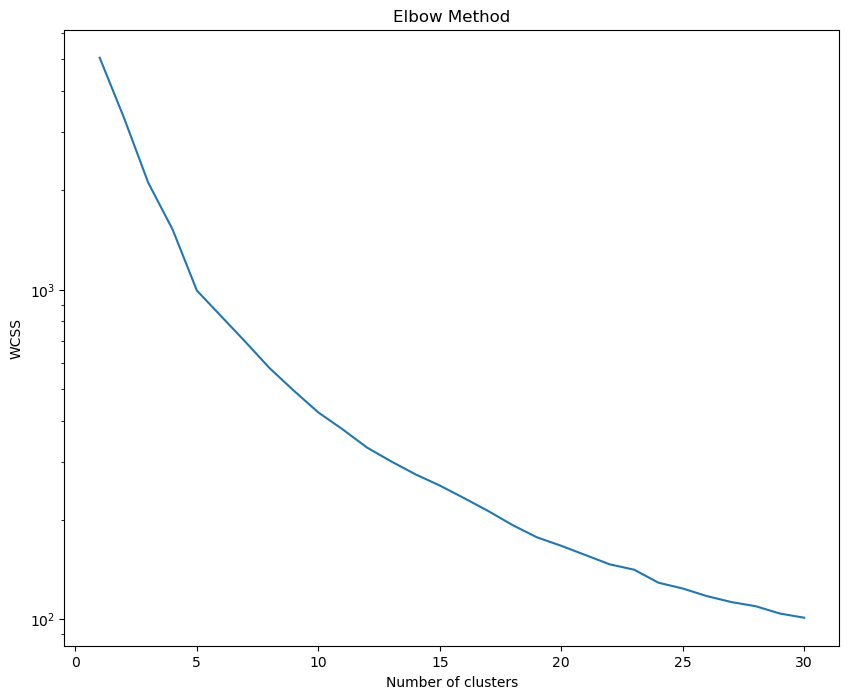

In [2914]:
# elbow analysis
wcss = []
for i in range(1, 31):  # 1 to 30
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# plot WCSS values
plt.figure(figsize=(10, 8))
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.yscale('log')
plt.show()

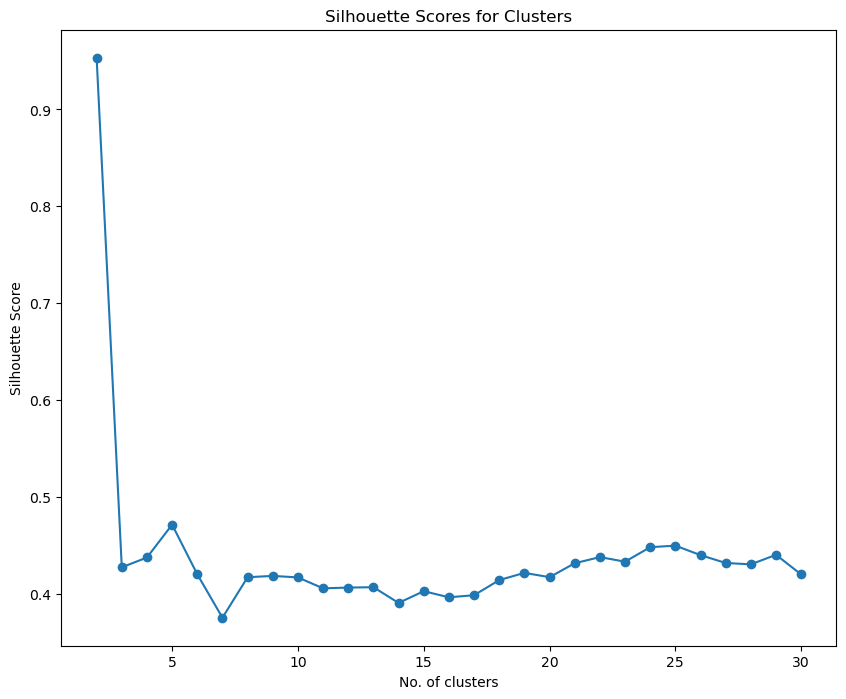

In [2915]:
# init and create loop
silhouette_scores = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# plot silhouette scores
plt.figure(figsize=(10, 8))
plt.plot(range(2, 31), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Clusters')
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette Score')
plt.show()

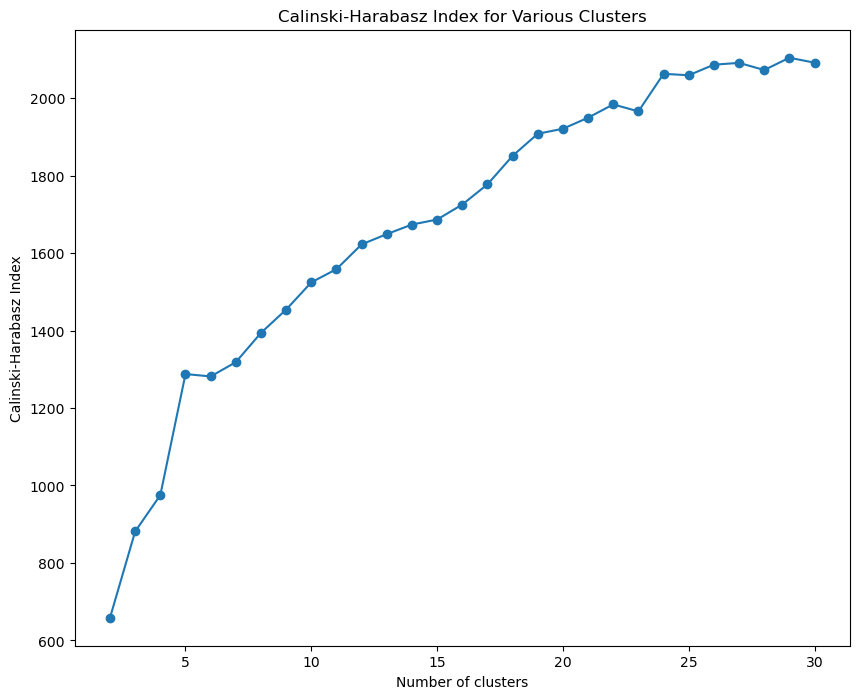

In [2916]:
# calinski-harabasz index
calinski_harabasz_scores = []
for i in range(2, 31):  # cannot compute with one cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    calinski_harabasz_scores.append(score)

# plot CH index
plt.figure(figsize=(10, 8))
plt.plot(range(2, 31), calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index for Various Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()

#### 4.1.1 Number of Clusters
The Elbow Method suggests a more gradual WCSS decrease from 6 clusters, while the Silhouette Score plateaus after 7, indicating stable cluster definition. The Calinski-Harabasz Index increases with more clusters and shows no clear plateau. Between 6 - 7 the gradient becomes more stable. Combining these insights, starting with 7 clusters would balance distinctness and model complexity, aligning with the goal of identifying meaningful English and Welsh energy consumption segments.

/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


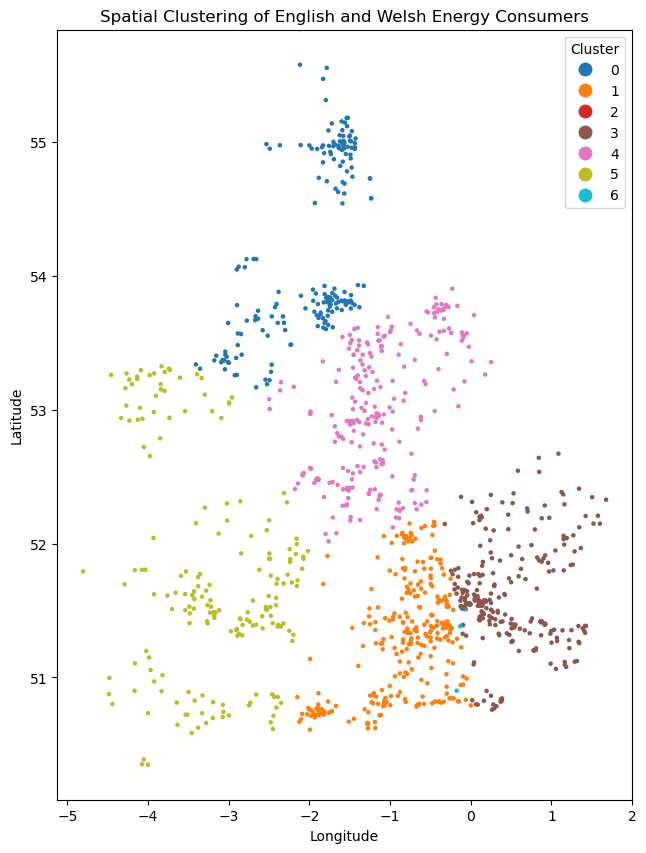

In [2918]:
# 7 clusters chosen
optimal_clusters = 7
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# cluster labels
joined_df['cluster'] = cluster_labels

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
joined_df.plot(column='cluster', ax=ax, categorical=True, markersize=5, legend=True, legend_kwds={'title': "Cluster"})

plt.title('Spatial Clustering of English and Welsh Energy Consumers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [2919]:
# below are calculations of the silhouette score using 'postcode' and 'LAD' as geographic identifiers.
# select relevant features for clustering
features = joined_df[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# apply K-means clustering, using 7 clusters
k = 7 
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# calc silhouette score to assess the quality of clustering
silhouette_avg = silhouette_score(X_scaled, labels)
print('average silhouette score for', k, 'clusters is:', silhouette_avg)

average silhouette score for 7 clusters is: 0.807069627829212


/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


A silhouette score of 0.807, suggests that the clusters are well-separated and clearly defined. This indicates that the segmentation of the dataset into seven clusters is effective, with each cluster likely representing distinct patterns of energy consumption.

#### 4.1.2 Segment Clusters by Quartile
Below we segment the 7 clusters into 1 of 4 consumption types outlined above.

In [2921]:
# calc total energy cons.
joined_df['total_energy'] = joined_df['n_gas_median_cons_kwh'] + joined_df['n_elec_median_cons_kwh']

# calc median total energy consumption for each cluster
cluster_median = joined_df.groupby('cluster')['total_energy'].median().sort_values()

# quartile cutoffs for total energy consumption among clusters
quantiles = cluster_median.quantile([0.25, 0.5, 0.75])

# to determine category based on quartiles
def consumption_category(value):
    if value <= quantiles.iloc[0]:
        return 'Low'
    elif value <= quantiles.iloc[1]:
        return 'Medium-Low'
    elif value <= quantiles.iloc[2]:
        return 'Medium-High'
    else:
        return 'High'

# map clusters to category
cluster_to_category = cluster_median.map(consumption_category).to_dict()
joined_df['consumption_section'] = joined_df['cluster'].map(cluster_to_category)

joined_df

,outcode,gas_median_cons_kwh,elec_median_cons_kwh,Count,n_gas_median_cons_kwh,n_elec_median_cons_kwh,geometry,LAD,mean annual income,dwelling_type: mobile,...,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),x,y,cluster,total_energy,consumption_section
0,AL1,11212.445815,2704.2,39038,0.287219,0.069271,POINT (-1.23428 54.57754),E06000002,35500.0,0.000344,...,0.113080,0.005071,0.361790,0.001200,0.038332,-1.234282,54.577542,0,0.356490,Medium-Low
2,AL2,12388.751514,2917.6,24211,0.511699,0.120507,POINT (-1.23429 54.57725),E06000002,35500.0,0.000344,...,0.113080,0.005071,0.361790,0.001200,0.038332,-1.234295,54.577255,0,0.632206,Medium-Low
1,AL10,9859.944538,2522.9,38933,0.253254,0.064801,POINT (-0.22457 51.77064),E07000241,44600.0,0.001065,...,0.123231,0.003644,0.347833,0.002088,0.030829,-0.224566,51.770635,3,0.318055,Low
7,AL7,8830.802190,2439.4,36930,0.239123,0.066055,POINT (-0.19593 51.80467),E07000241,44600.0,0.001065,...,0.123231,0.003644,0.347833,0.002088,0.030829,-0.195926,51.804673,3,0.305177,Low
8,AL8,11826.127001,2851.3,13596,0.869824,0.209716,POINT (-0.24703 51.79689),E07000241,44600.0,0.001065,...,0.123231,0.003644,0.347833,0.002088,0.030829,-0.247026,51.796893,3,1.079540,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,SA14,8921.626667,2535.6,35356,0.252337,0.071716,POINT (-4.07525 51.80427),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.075254,51.804268,5,0.324053,Medium-High
1424,SA15,8822.299817,2280.1,37743,0.233747,0.060411,POINT (-4.16227 51.80093),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.162265,51.800932,5,0.294158,Medium-High
1425,SA16,8842.560518,2241.8,8291,1.066525,0.270390,POINT (-4.29071 51.69504),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.290709,51.695043,5,1.336915,Medium-High
1426,SA18,10453.039155,2522.4,30428,0.343534,0.082897,POINT (-4.03219 51.80476),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.032185,51.804761,5,0.426431,Medium-High


### 4.3 Correlation between consumption segments and socioeconomic factors
Energy consumers and now clustered and segmented. Below, each segment is assessed against socio-economic data to understand which socioeconomic factors are correlated with each segment. There are three steps conducted in this analysis:

- Data Preparation: Energy consumption is categorised into four segments (*Low, Medium-Low, Medium-High, High*) and coded numerically for regression. Socioeconomic factors are prepared as independent variables.
- Regression Analysis per Cluster: Multiple linear regressions are conducted for each of the 10 clusters, analysing the impact of socioeconomic factors on energy consumption levels.
- Results Compilation: Regression coefficients for each factor are compiled into a DataFrame, illustrating their correlations with energy consumption across clusters.

In [2923]:
# init. results dict.
cluster_results = {}

# socioeconomic factors object
socioeconomic_cols = [
    "mean annual income", "dwelling_type: mobile", "dwelling_type: flat",
    "dwelling_type: detached house", "dwelling_type: semi-detached",
    "dwelling_type: terraced", "no central heating", "1 central heating",
    "2+ central heating (renewable)", "2+ central heating (non-renewable)"
]

# perform regression for each cluster using weighted averages
for cluster in joined_df['cluster'].unique():
    cluster_data = joined_df[joined_df['cluster'] == cluster]
    # ensure sufficient data
    if len(cluster_data) < 2:
        print(f"Not enough data to fit a model for cluster {cluster}")
        continue
    X = cluster_data[socioeconomic_cols]
    y = cluster_data['total_energy']
    model = LinearRegression()
    model.fit(X, y)
    # regression coefficients & intercept stored in dict above
    cluster_results[cluster] = {
        'coefficients': model.coef_,
        'intercept': model.intercept_
    }

# create df to hold coefficients
# prepare data for df construction
data_for_df = {}
for cluster, data in cluster_results.items():
    # coefficients + intercept
    data_for_df[cluster] = np.append(data['coefficients'], data['intercept'])

# columns: socioeconomic factors + 'Intercept'
columns_for_df = socioeconomic_cols + ['Intercept']

# construct & print results df
regression_results_df = pd.DataFrame(data_for_df, index=columns_for_df).T
regression_results_df.index.name = 'Cluster'

regression_results_df

Not enough data to fit a model for cluster 2


,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),Intercept
Cluster,,,,,,,,,,,
0,0.000110,-10157.925694,-9997.684611,-9996.470178,-9995.438998,-10001.411600,10111.955553,9984.653464,10053.185981,10117.962987,-3.771577
3,0.000084,6020.854609,6061.076509,6070.339503,6061.229644,6064.290519,-5772.595734,-6051.933389,-6124.227870,-6067.424204,-9.140531
1,0.000012,4695.866007,4670.908607,4689.236629,4671.505440,4677.102444,-4402.184791,-4698.562367,-4697.013225,-4703.470232,7.133159
4,-0.000012,782.846380,744.338980,737.792328,739.266682,736.007978,-699.796864,-741.288616,-731.285046,-693.667449,0.213106
6,-0.002327,19.917984,248.227614,-155.255492,-148.506991,97.238623,33.984014,-9.660391,-5.773817,43.071933,180.797679
5,0.000026,13537.333626,13686.014293,13688.455072,13684.251562,13679.051497,-13481.307403,-13651.855977,-13852.252641,-13664.968703,-13.532564


### 5.0 Results, Discussion & Conclusion
During the multilinear regression analysis, there was "Not enough data to fit a model for cluster 2". Thus, Cluster 2 was excluded from model fitting to preserve the statistical integrity of the analysis.

The multilinear regression analysis on English and Welsh energy consumption reveals varied impacts of socioeconomic factors across different clusters, highlighting how regional and housing characteristics influence energy usage. Higher income often correlates with increased energy consumption, potentially due to larger homes and greater appliance use. Housing types such as mobile homes and flats frequently exhibit negative coefficients, indicating lower energy use. Heating systems also play a crucial role, with certain clusters showing that advanced heating technologies may lead to higher energy use, likely due to inefficiencies in older systems. Notably, Cluster 6 demonstrates significant variance in how socioeconomic factors converge, with its high consumption section influenced by a mix of dwelling types and heating efficiencies, underscoring the nuanced interplay of factors that dictate energy consumption within specific clusters.

The analysis of energy consumption in England and Wales shows clear patterns influenced by housing types, heating systems, and income levels. The High Consumption Segment is primarily affected by larger homes such as detached and semi-detached houses, which typically use more energy. Inefficiencies in advanced heating systems also contribute to higher consumption. Conversely, the Medium-Low Consumption Segment includes smaller residences like flats and mobile homes, which generally use less energy, with subtle impacts from income differences. The Low Consumption Segment benefits from traditional heating systems that tend to be more energy-efficient or involve better energy conservation measures. 

#### 5.1 Limitations
One limitation of this analysis is integrating data across different geographic levels, such as postcode-level energy consumption and Local Authority District-level socioeconomic data, which may introduce inaccuracies. Additionally, the lack of comprehensive data for all Local Authority Districts could lead to a biased analysis of energy consumption patterns.

Moreover, the use of unsupervised clustering might miss nuanced subgroups due to its sensitivity to outliers and data density variations. Also, the regression analysis may not include all relevant variables affecting energy consumption, potentially overlooking significant factors influencing energy use patterns.

#### 5.2 Opportunities for further research

This study sets the stage for future research by facilitating the inclusion of additional variables at the clustering and socioeconomic stages, enhancing our understanding of energy consumption patterns. Subsequent studies could incorporate environmental factors such as weather conditions and renewable energy access to examine their impact alongside socioeconomic traits. Furthermore, employing time series analysis could provide forecasts of future consumption trends and policy impacts, aiding policymakers in proactive decision-making.

### References

Balashankar, A. et al. (2022) ‘Targeted policy recommendations using outcome-aware clustering’, ACM SIGCAS/SIGCHI Conference on Computing and Sustainable Societies (COMPASS). doi:10.1145/3530190.3534797. 

Dou, Y., Tan, S. and Xie, D. (2023) ‘Comparison of machine learning and statistical methods in the field of Renewable Energy Power Generation Forecasting: A mini review’, Frontiers in Energy Research, 11. doi:10.3389/fenrg.2023.1218603. 

Forootan, M.M. et al. (2022) ‘Machine learning and deep learning in energy systems: A Review’, Sustainability, 14(8), p. 4832. doi:10.3390/su14084832. 

Jain, N. and Ahuja, V. (2014) ‘Segmenting online consumers using K-means cluster analysis’, International Journal of Logistics Economics and Globalisation, 6(2), p. 161. doi:10.1504/ijleg.2014.068274. 

Rehmatulla, N., Calleya, J. and Smith, T. (2017) ‘The implementation of technical energy efficiency and CO 2 emission reduction measures in shipping’, Ocean Engineering, 139, pp. 184–197. doi:10.1016/j.oceaneng.2017.04.029. 

Słupik, S., Kos-Łabędowicz, J. and Trzęsiok, J., 2021. An innovative approach to energy consumer segmentation—a behavioural perspective. the case of the eco-bot project. Energies, 14(12), p.3556.